## Tarea

Importa las librerías necesarias para resolver los siguientes ejercicios (no necesitaras ninguna que no hayamos utilizado nosotros)

In [14]:
import geopandas as gpd 
import pandas as pd
import matplotlib.pyplot as plt
import re
import matplotlib.patches as mpatches
from shapely.ops import nearest_points

#### 1.
Grafica la división estatal de México (usando el shapefile que usamos en la clase) en diferentes tonos de algún color que elijas. Pintalos según su área. Los estados más oscuros siendo los más grandes

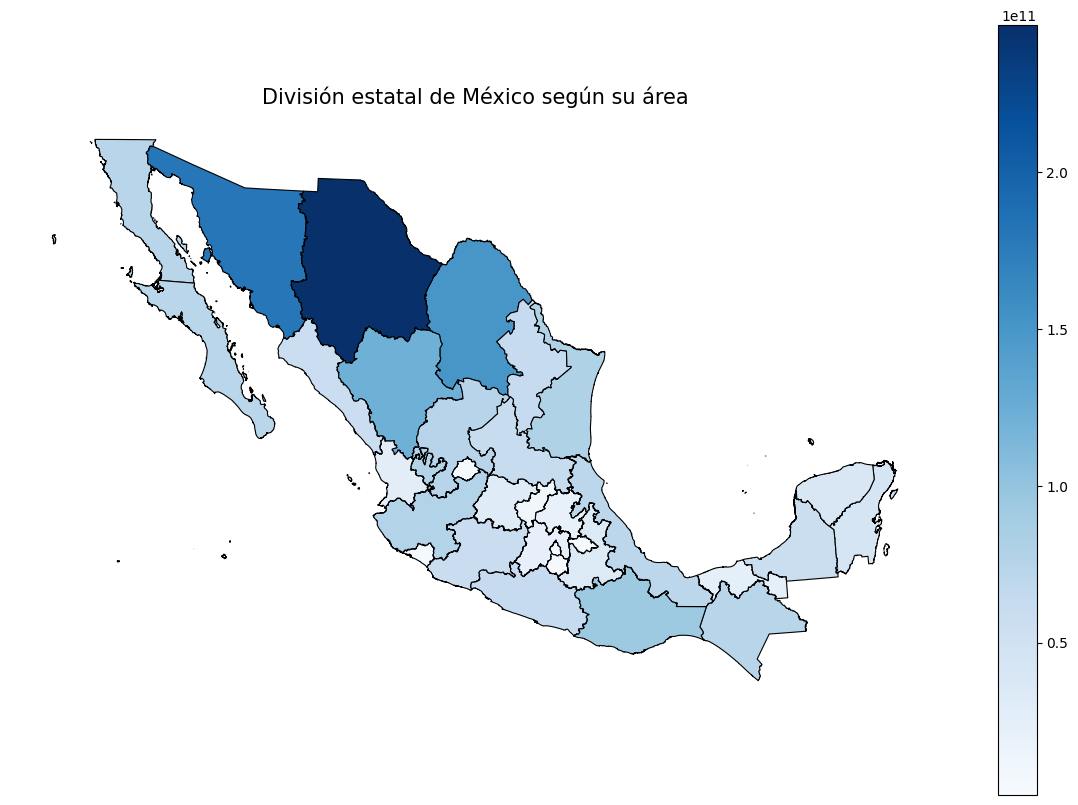

In [15]:
# Define el path al shapefile
estados_shapefile_path = '/usr/src/app/Estados/conjunto_de_datos/00ent.shp'

# Cargar el shapefile
estados_gdf = gpd.read_file(estados_shapefile_path)

# Calcular el área de cada estado
estados_gdf['area'] = estados_gdf.geometry.area

# Graficar el mapa
fig, ax = plt.subplots(1, 1, figsize=(15, 10)) 
estados_gdf.plot(column='area', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='black', legend=True)
ax.set_title('División estatal de México según su área', fontsize=15)
ax.set_axis_off()


plt.show()


#### 2.
Crea un área de 5km alrededor de cada escuela. Calcula el área total cubierta y saca el porcentaje de área del país cubierta por escuelas.
Tip: cuidado con las intersecciones y las unidades!

In [16]:
# Define el paths al shapefile
escuelas_shapefile_path = '/usr/src/app/Escuelas/conjunto_de_datos/denue_inegi_61_.shp'

# Cargar shapefile
escuelas_gdf = gpd.read_file(escuelas_shapefile_path)

# Convertir a UTM Zone 14N pa México
escuelas_gdf = escuelas_gdf.to_crs(epsg=32614)
estados_gdf = estados_gdf.to_crs(epsg=32614)

# Buffer de 5 km alrededor de cada escuela
escuelas_gdf['buffer_5km'] = escuelas_gdf.geometry.buffer(5000)
dissolved_buffers = escuelas_gdf['buffer_5km'].unary_union

# Calcular el área total de México
total_mexico_area = estados_gdf.geometry.area.sum()

# Calcular el área cubierta por los buffers
covered_area = dissolved_buffers.area

# Calcular el porcentaje de área cubierta
percentage_covered = (covered_area / total_mexico_area) * 100

print(f'Porcentaje de área cubierta por las escuelas: {percentage_covered:.2f}%')


Porcentaje de área cubierta por las escuelas: 15.95%


#### 3.
Calcula la distancia entre la CDMX y todos los demás estados de la república. 
Bonus: punto extra si lo haces usando las fronteras y no los centroides.

In [17]:
# Calcular fronteras
cdmx = estados_gdf[estados_gdf['NOMGEO'] == 'Ciudad de México'].geometry.unary_union

# Calcular la distancia entre la CDMX y todos los demás estados
dist = {}
for est, row in estados_gdf.iterrows():
    if row['NOMGEO'] != 'Ciudad de México':
        estado = row['geometry']
        distancia = cdmx.distance(estado)
        dist[row['NOMGEO']] = distancia


for estado, distancia in dist.items():
    print(f"Distancia entre Ciudad de México y {estado}: {distancia:.2f} metros")


Distancia entre Ciudad de México y Aguascalientes: 381142.15 metros
Distancia entre Ciudad de México y Baja California: 1664041.95 metros
Distancia entre Ciudad de México y Baja California Sur: 1137763.24 metros
Distancia entre Ciudad de México y Campeche: 685629.45 metros
Distancia entre Ciudad de México y Coahuila de Zaragoza: 575866.24 metros
Distancia entre Ciudad de México y Colima: 433447.67 metros
Distancia entre Ciudad de México y Chiapas: 580820.15 metros
Distancia entre Ciudad de México y Chihuahua: 918640.13 metros
Distancia entre Ciudad de México y Durango: 621515.22 metros
Distancia entre Ciudad de México y Guanajuato: 129327.87 metros
Distancia entre Ciudad de México y Guerrero: 50207.52 metros
Distancia entre Ciudad de México y Hidalgo: 28627.12 metros
Distancia entre Ciudad de México y Jalisco: 306249.40 metros
Distancia entre Ciudad de México y México: 0.00 metros
Distancia entre Ciudad de México y Michoacán de Ocampo: 88417.00 metros
Distancia entre Ciudad de México y

#### 4.
Metete al INEGI y descarga el shapefile de nombre "Servicios profesionales, científicos y técnicos" de 2023 (más info en el READ ME y en la presentación). Grafica las escuelas (sólo las primarias, secundarias y prepas), y los servicios que se muestran en este shapefile (las escuelas de un color y los servicios de otro). También grafica los estados. Comenta si ves alguna relación entre la localización de estas escuelas y los servicios.

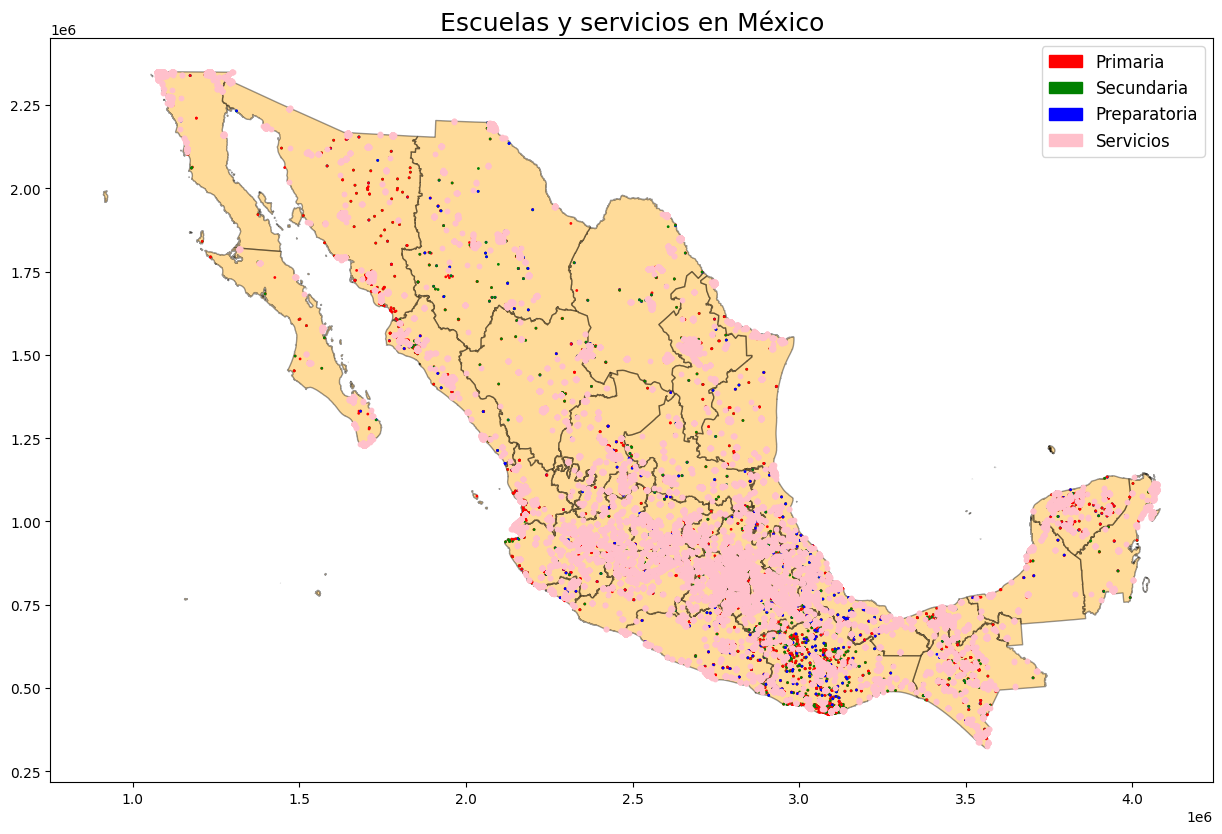

In [20]:
servicios_shapefile_path = '/usr/src/app/Servicios/conjunto_de_datos/denue_inegi_54_.shp'
servicios_gdf = gpd.read_file(servicios_shapefile_path)


# Cambiar el CRS 
mexico_crs = "EPSG:6362"
escuelas = escuelas_gdf.to_crs(mexico_crs)
servicios = servicios_gdf.to_crs(mexico_crs)
estados_gdf = estados_gdf.to_crs(mexico_crs)

# Unir las escuelas con los estados
escuelas_est= gpd.sjoin(escuelas, estados_gdf, how='inner', predicate='within')

# Obvio un regex que seguro fue idea de McCadden
regex_primaria = r"(?i)(primaria|escuela básica|escuela elemental)"
regex_secundaria = r"(?i)(secundaria|escuela media|educación media)"
regex_prepa = r"(?i)(preparatoria|bachillerato|prepa|colegio)"

# Determinar color de las escuelas
def assign_color_escuela(row):
    if pd.notna(row['nom_estab']):
        if re.search(regex_primaria, row['nom_estab']):
            return 'red'  
        elif re.search(regex_secundaria, row['nom_estab']):
            return 'green'  
        elif re.search(regex_prepa, row['nom_estab']):
            return 'blue'  
    return 'gray' 


escuelas_est['color'] = escuelas_est.apply(assign_color_escuela, axis=1)

# Gráficar
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

estados_gdf.plot(ax=ax, color='orange', edgecolor='black', alpha=0.4)

escuelas_o = escuelas_est[escuelas_est['color']!='gray']
escuelas_o.plot(ax=ax, color=escuelas_o['color'], markersize=1, legend=True)

legend_patches_escuelas = [
    mpatches.Patch(color='red', label='Primaria'),
    mpatches.Patch(color='green', label='Secundaria'),
    mpatches.Patch(color='blue', label='Preparatoria'),
    mpatches.Patch(color='pink', label='Servicios')
]
ax.legend(handles=legend_patches_escuelas, loc='upper right', fontsize=12)

servicios.plot(ax=ax, color='pink', markersize=10, legend=True)

ax.set_aspect('equal')
ax.set_title("Escuelas y servicios en México", fontsize=18)

plt.show()